In [1]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


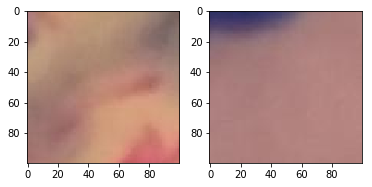

In [2]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

In [3]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)
#w_colors = [w_r, w_g, w_b]

In [5]:
mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

print(np.shape(mask))

(100, 100, 3)


In [6]:
image = mask * X_batch

In [8]:
def train_loop(iteration):
    # train loop:
    correct = 0
    total = 0
    loss_list = []
    acc = []
    TP = 0
    TN = 0
    AP = 0
    AN = 0
    for i in range(iteration):
        _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
        loss_list.append(loss_i)
        if i%1000 == 0:
            print('loss is ', loss_i)
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
        TPi, TNi, APi, ANi = stat(prediction, truth)
        TN = TN + TNi
        AP = AP + APi
        AN = AN + ANi
        
    sensitivity = TP/AN
    specificity = TN/AP
    acc = correct/total
    print("Accuracy is:")
    print(acc)
    print("Sensitivity is:")
    print(sensitivity)
    print("Specificity is:")
    print(specificity)
    return loss_list, sensitivity, specificity, acc
    

In [9]:
def stat(prediction, truth):
    pred_pos = np.where(prediction == 1)
    label_pos = np.where(truth == 1)
    TP = len(np.intersect1d(pred_pos, label_pos))

    pred_neg = np.where(prediction == 0)
    label_neg = np.where(truth == 0)
    TN = len(np.intersect1d(pred_neg, label_neg))
    
    AP = len(label_pos[0])
    AN = len(label_pos[0])
    return TP, TN, AP, AN
             
    specificity = TN/AP
    sensitivity = TP/AN

## Learning_rate = 0.0001

In [10]:

net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.0001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [11]:
# this code tells our batch_generator to generate training batches:

sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

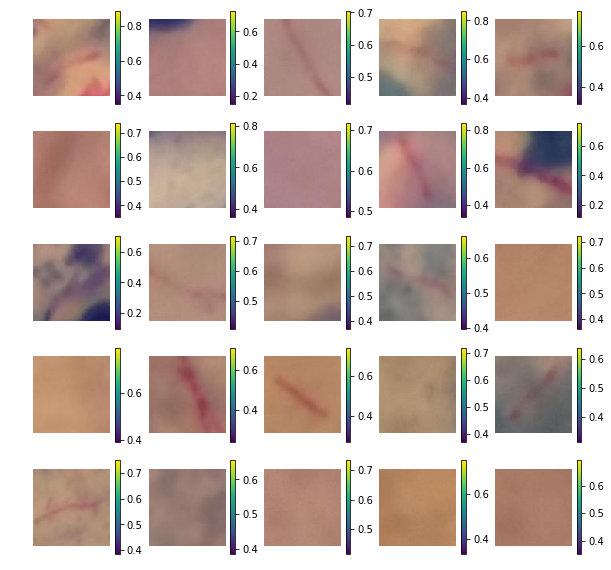

In [12]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [ ]:
loss, sensitivity, specificity, acc = train_loop(10000)

loss is  []


In [ ]:
# plot examples 
plot_examples(image.eval())

In [127]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})

# pass through test set:
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Test accuracy is:")
print(acc)

Test accuracy is:
0.9606777493606138


In [128]:
sess.run(w_r)

1.0040064

In [129]:
sess.run(w_g)

0.9964923

In [130]:
sess.run(w_b)

1.0

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


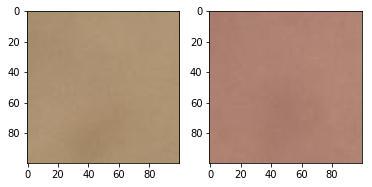

In [18]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [19]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)
#w_colors = [w_r, w_g, w_b]

mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

print(np.shape(mask))

image = mask * X_batch

(100, 100, 3)


## learning rate = 0.001

In [20]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [21]:
# train loop:
correct = 0
total = 0
for i in range(6000):
    _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
    if i%1000 == 0:
        print(loss_i)
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Accuracy is:")
print(acc)

11.816944
nan
nan
nan
nan
nan
Accuracy is:
0.5683842904345644


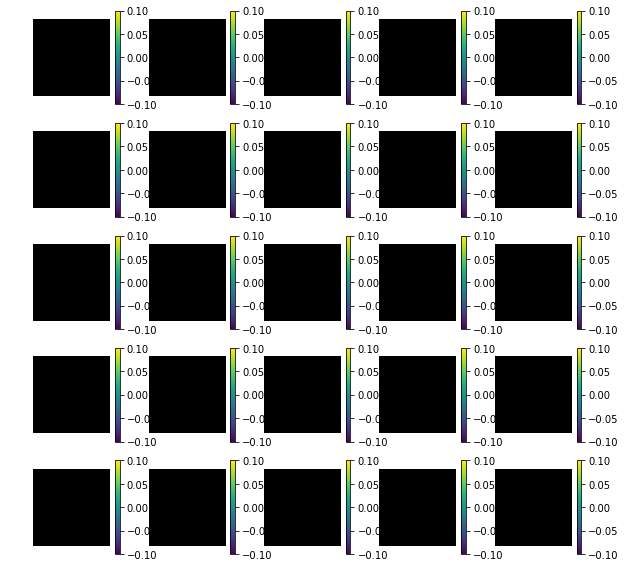

In [22]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [23]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})

# pass through test set:
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Test accuracy is:")
print(acc)

Test accuracy is:
0.5607416879795396


In [24]:
sess.run(w_r)

nan

In [25]:
sess.run(w_g)

nan

In [26]:
sess.run(w_b)

1.0

### learning rate = 0.00001

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


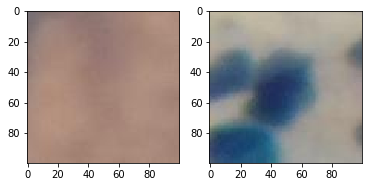

In [27]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [28]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)
#w_colors = [w_r, w_g, w_b]

mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

print(np.shape(mask))

image = mask * X_batch

(100, 100, 3)


In [29]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.00001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [30]:
# train loop:
correct = 0
total = 0
for i in range(6000):
    _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
    if i%1000 == 0:
        print(loss_i)
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Accuracy is:")
print(acc)

0.8966404
0.5275183
0.3194164
0.35519364
0.24999961
0.25494456
Accuracy is:
0.8643554728344974


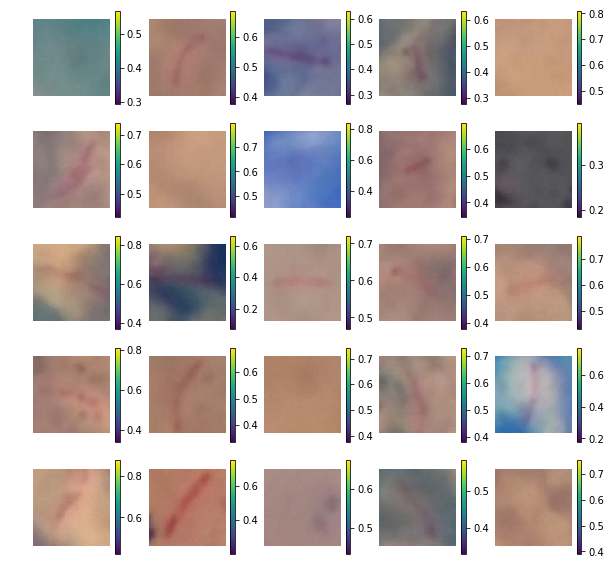

In [31]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [32]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})

# pass through test set:
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Test accuracy is:")
print(acc)

Test accuracy is:
0.920076726342711


In [33]:
sess.run(w_r)

0.9943543

In [34]:
sess.run(w_g)

1.003

In [35]:
sess.run(w_b)

1.0

### learning rate = 0.01

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


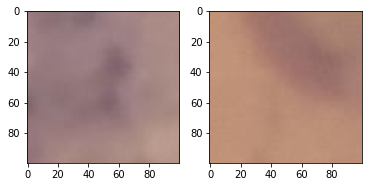

In [36]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [37]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)
#w_colors = [w_r, w_g, w_b]

mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

print(np.shape(mask))

image = mask * X_batch

(100, 100, 3)


In [38]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [39]:
# train loop:
correct = 0
total = 0
for i in range(6000):
    _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
    if i%1000 == 0:
        print(loss_i)
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Accuracy is:")
print(acc)

3.879322
0.6769299
0.67705977
0.648934
0.6853719
0.7352029
Accuracy is:
0.567652348488017


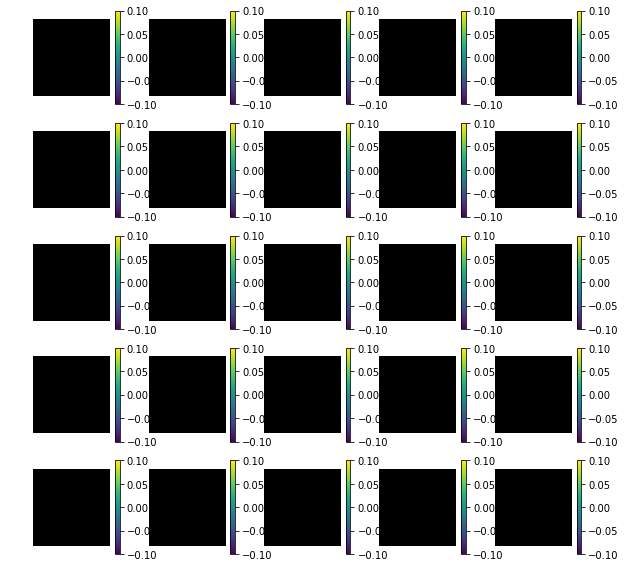

In [40]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [41]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})

# pass through test set:
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Test accuracy is:")
print(acc)

Test accuracy is:
0.5642583120204604


In [42]:
sess.run(w_r)

nan

In [43]:
sess.run(w_g)

nan

In [44]:
sess.run(w_b)

1.0

In [10]:
# train loop:
correct = 0
total = 0
for i in range(100):
    _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
    if i%1000 == 0:
        print(loss_i)
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print("Accuracy is:")
print(acc)


15.096936
Accuracy is:
0.5653125
